# =========================
# 1. ライブラリ読み込み
# =========================

In [1]:
import warnings
warnings.simplefilter('ignore')

import re
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
from sklearn.model_selection import StratifiedKFold


from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install wordcloud
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoshito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# =========================
# 2. データ読み込み
# =========================

In [2]:
# マスタデータの読み込み
train = pd.read_csv('/コンペ/スパムメール分類コンペ/ファイル/train_master.csv', sep=',',index_col=0)
train.head()

,label
file_name,
train_0000.txt,0
train_0001.txt,0
train_0002.txt,1
train_0003.txt,1
train_0004.txt,0


In [3]:
# データサイズの確認
print(train.shape)
print('trainデータ', len(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/train2/train_*.txt')))
print('testデータ', len(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/test2/test_*.txt')))

(2586, 1)
trainデータ 2586
testデータ 2586


In [4]:
# trainデータの作成
text_train = []
for file_name in np.sort(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/train2/train_*.txt')):
  with open(file_name) as f:
    text = f.read()
  text_train.append(text)
train['text'] = text_train
train.head()

,label,text
file_name,,
train_0000.txt,0,Subject: re : buyback / deficiency deals works...
train_0001.txt,0,Subject: fw : stress relief\n- - - - - origina...
train_0002.txt,1,"Subject: from mrs . juliana\ndear friend ,\npl..."
train_0003.txt,1,Subject: [ wrenches ] 68 % off dreamweaver mx ...
train_0004.txt,0,Subject: y 2 k - texas log\nname home pager\ng...


In [5]:
# testデータ作成
text_test = []
for file_name in sorted(glob.glob('/コンペ/スパムメール分類コンペ/ファイル/test2/test_*.txt')):
    with open(file_name) as f:
        text = f.read()
    text_test.append(text)
test = pd.DataFrame(index=[f'test_{str(x).zfill(4)}.txt' for x in range(len(text_test))], data={'text':text_test})
test.head()

,text
test_0000.txt,Subject: join the thousands who are now sp @ m...
test_0001.txt,Subject: potential list fo 9 / 00\ndaren :\npe...
test_0002.txt,Subject: bounce skel @ iit . demokritos . gr :...
test_0003.txt,Subject: hpl meter # 981488 paris tenaska hpl\...
test_0004.txt,"Subject: hpl nom for august 3 , 2000\n( see at..."


# =========================
# 3. EDA（文字数・単語数・頻出単語）
# =========================

#スパムメールと普通のメールの単語を、単語の出現頻度に応じて大きさを変えて表示する

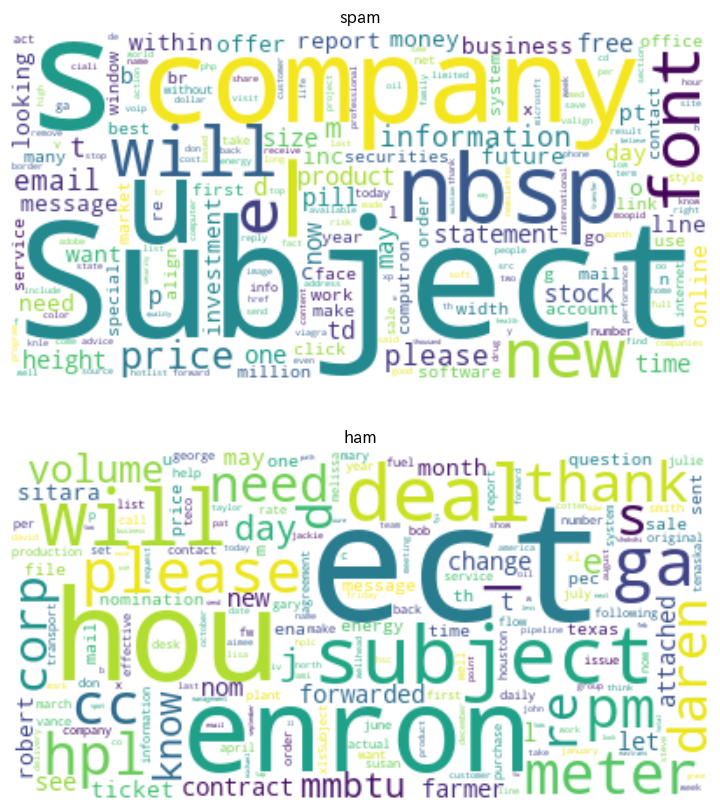

In [6]:
spam = WordCloud(background_color='white', collocations=False).generate(''.join(train[train['label']==1]['text']))
ham = WordCloud(background_color='white', collocations=False).generate(''.join(train[train['label']==0]['text']))
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(spam, interpolation='bilinear')
plt.axis('off')
plt.title('spam')

plt.subplot(2, 1, 2)
plt.imshow(ham, interpolation='bilinear')
plt.axis('off')
plt.title('ham')

plt.show()

#スパムメールと普通のメールの分布を棒グラフで表示

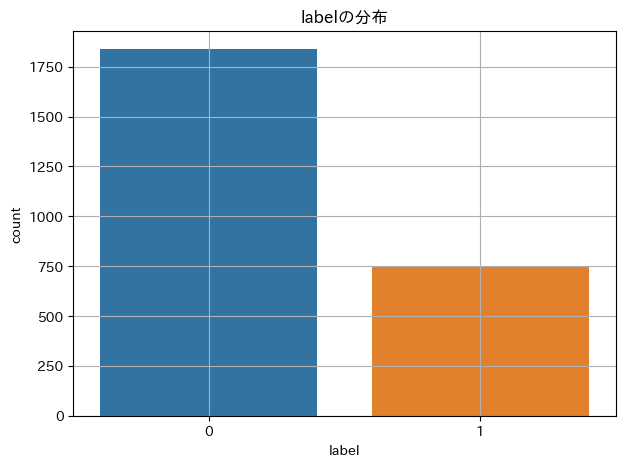

In [7]:
plt.figure(figsize=(7, 5))
sns.countplot(x=train['label'], data=train)
plt.title('labelの分布')
plt.grid()
plt.show()

In [8]:
train['label'].value_counts()

label
0    1839
1     747
Name: count, dtype: int64

#文字数や単語数を情報として得る

In [9]:
train['text_length'] = train['text'].apply(lambda x: len(x))
train['num_words'] = train['text'].apply(lambda x: len(x.split()))

test['text_length'] = test['text'].apply(lambda x: len(x))
test['num_words'] = test['text'].apply(lambda x: len(x.split()))
train.head()

,label,text,text_length,num_words
file_name,,,,
train_0000.txt,0,Subject: re : buyback / deficiency deals works...,925,207
train_0001.txt,0,Subject: fw : stress relief\n- - - - - origina...,569,138
train_0002.txt,1,"Subject: from mrs . juliana\ndear friend ,\npl...",2831,538
train_0003.txt,1,Subject: [ wrenches ] 68 % off dreamweaver mx ...,565,108
train_0004.txt,0,Subject: y 2 k - texas log\nname home pager\ng...,520,130


#label別の文字数の比較を行う棒グラフを表示

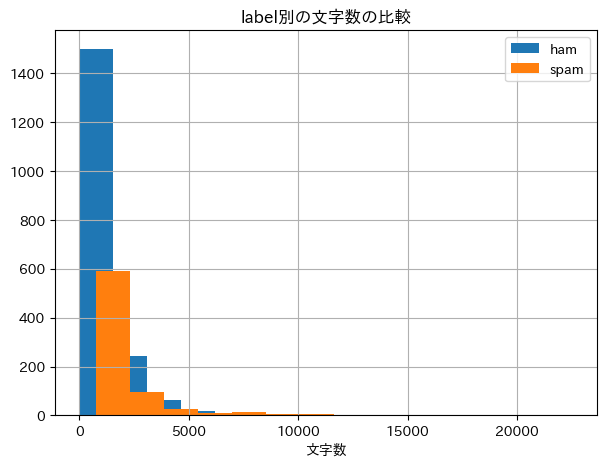

In [10]:
# グラフの幅の統一のため、binを設定
n_bin = 15
x_max = train['text_length'].max()
x_min = train['text_length'].min()
bins = np.linspace(x_min, x_max, n_bin)

plt.figure(figsize=(7, 5))
plt.hist(train[train['label']==0]['text_length'], label='ham', bins=bins)
plt.hist(train[train['label']==1]['text_length'], label='spam', align='right', bins=bins)
plt.title('label別の文字数の比較')
plt.xlabel('文字数')
plt.legend()
plt.grid()
plt.show()


#label別の単語数の比較を行う棒グラフを表示

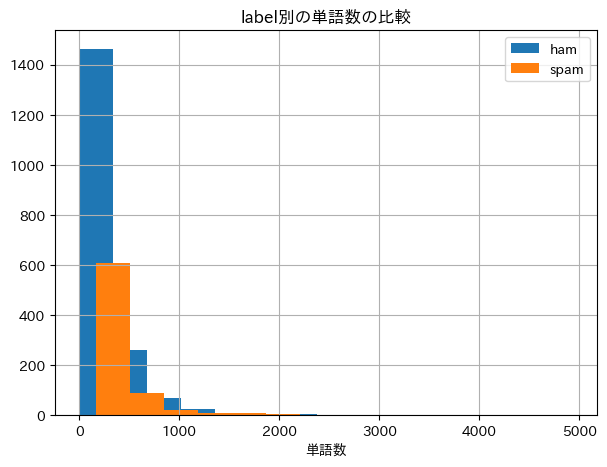

In [11]:
n_bin = 15
x_max = train['num_words'].max()
x_min = train['num_words'].min()
bins = np.linspace(x_min, x_max, n_bin)

plt.figure(figsize=(7, 5))
plt.hist(train[train['label']==0]['num_words'], label='ham', bins=bins)
plt.hist(train[train['label']==1]['num_words'], label='spam', align='right', bins=bins)
plt.title('label別の単語数の比較')
plt.xlabel('単語数')
plt.legend()
plt.grid()
plt.show()


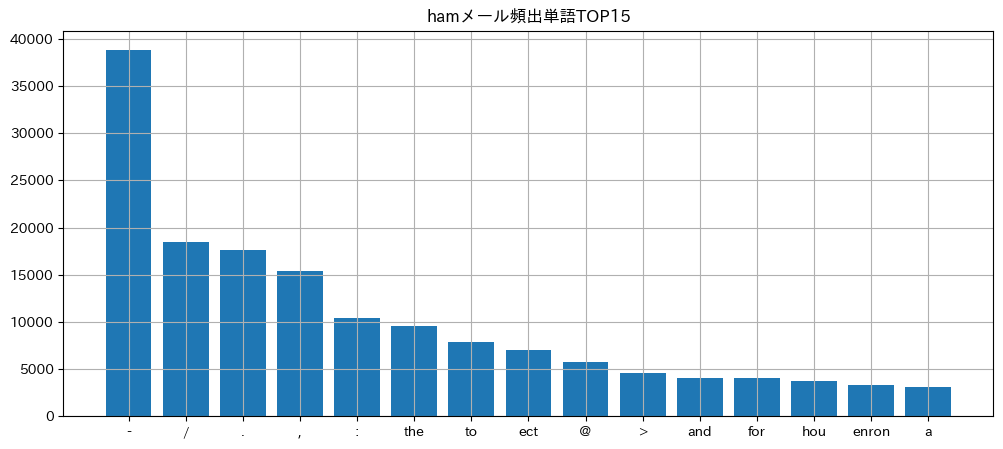

In [12]:
#hamに出現する単語の頻度の可視化

# corpusに全ての出現単語を要素として取得
corpus=[]
for x in train[train['label']==0]['text'].str.split():
    for i in x:
        corpus.append(i)

# corpusを辞書型で集計
plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('hamメール頻出単語TOP15')
plt.grid()
plt.show()

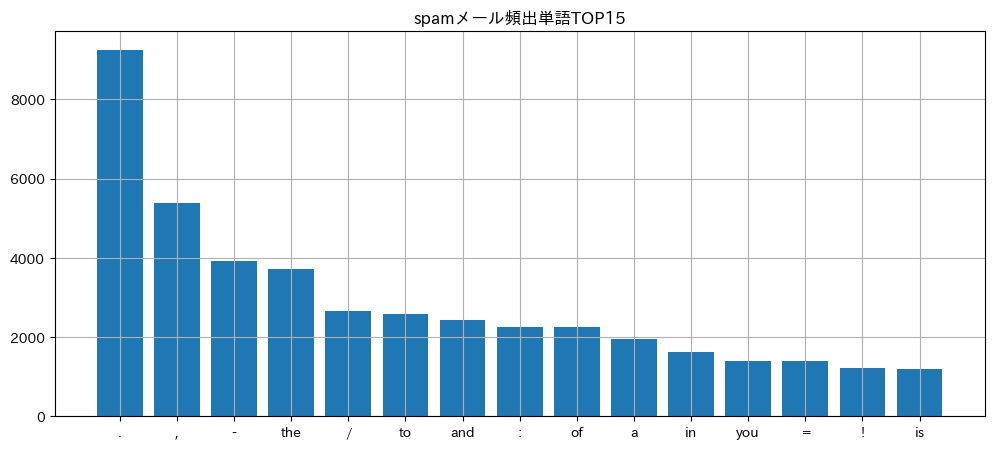

In [13]:
#spamに出現する単語の頻度の可視化
corpus=[]
for x in train[train['label']==1]['text'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('spamメール頻出単語TOP15')
plt.grid()
plt.show()

# =========================
# 4. 前処理（小文字化・ストップワード除去・ステミング）
# =========================

#textカラムの内容を小文字化する

In [14]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

#文章の中で頻繁に出現するにもかかわらず、文の主要な意味や感情にほとんど貢献しない単語を表示

In [15]:
# stopwordの中身を一部確認
stop_words = stopwords.words('english')
print('stopwordsの一部を確認:', stop_words[:5])

stopwordsの一部を確認: ['a', 'about', 'above', 'after', 'again']


In [16]:
# 1つのデータのtextに対して「単語ごとの分割」→「stop_wordsでないものを取り出す」→「記号以外を取り出す」という処理を行う関数を作成
def remove_stopwords(text):
    words = ' '.join([re.sub('[^a-zA-Z]+', '', word) for word in text.split() if word not in stop_words])
    return words

In [17]:
# 上記関数をデータセットに適用
train['text_remove'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text_remove'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

,label,text,text_length,num_words,text_remove
file_name,,,,,
train_0000.txt,0,subject: re : buyback / deficiency deals works...,925,207,subject buyback deficiency deals worksheet e...
train_0001.txt,0,subject: fw : stress relief\n- - - - - origina...,569,138,subject fw stress relief original messag...
train_0002.txt,1,"subject: from mrs . juliana\ndear friend ,\npl...",2831,538,subject mrs juliana dear friend please surp...
train_0003.txt,1,subject: [ wrenches ] 68 % off dreamweaver mx ...,565,108,subject wrenches dreamweaver mx flier ali...
train_0004.txt,0,subject: y 2 k - texas log\nname home pager\ng...,520,130,subject k texas log name home pager george g...


#text_removeをステミングする
`text_remove` カラムの単語をステミングして、同じ意味の単語を統一。  
  これにより、類義語や活用形の違いによる特徴量の分散を減らし、モデルがより正確に学習できるようにする。

試行としてステミングなしのモデルと比較したところ、ステミングを行わない場合は
単語のバリエーションがそのままBoWに反映され、語彙数が増加していた。

語彙数削減により不要なノイズが減り、単語間の意味的距離が縮まったため、F1スコアが向上した。

（例）
- running → run
- working → work
- meeting → meet

このことから、本タスクにおいてステミング処理は有効であると判断し、最終処理に採用した。

In [18]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

def stemmed_words(text):
    stemmer = SnowballStemmer("english", True)
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

train["text_remove"] = train["text_remove"].apply(stemmed_words)
test["text_remove"] = test["text_remove"].apply(stemmed_words)

#textカラムを削除

In [19]:
train = train.drop(["text"], axis=1)
test = test.drop(["text"], axis=1)

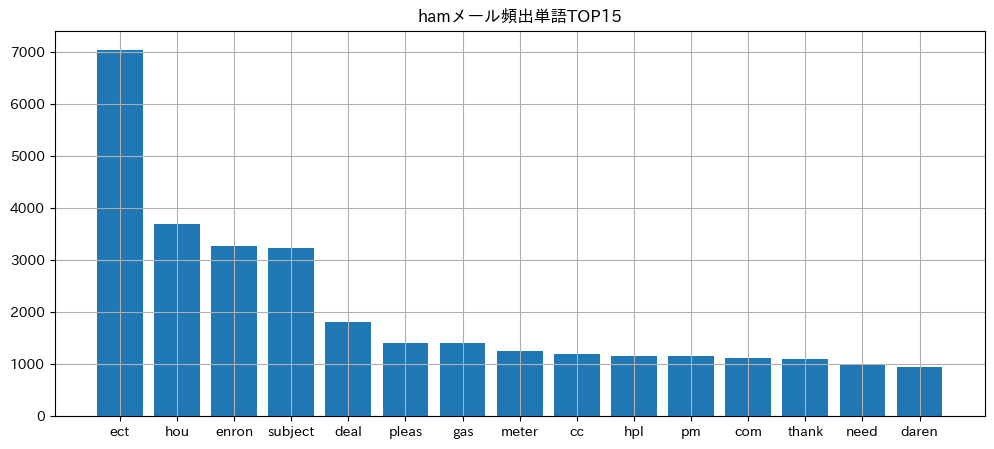

In [20]:
#hamに出現する単語の頻度の可視化
corpus=[]
for x in train[train['label']==0]['text_remove'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('hamメール頻出単語TOP15')
plt.grid()
plt.show()


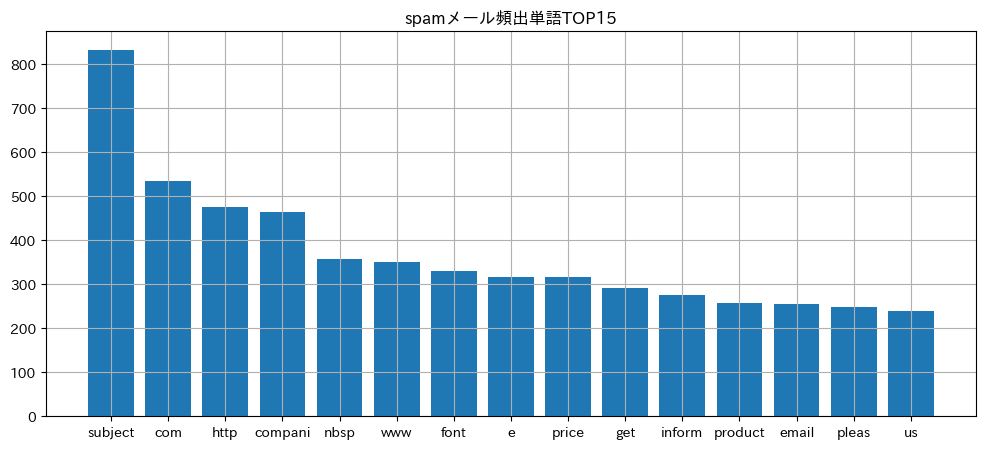

In [21]:
#spamに出現する単語の頻度の可視化
corpus=[]
for x in train[train['label']==1]['text_remove'].str.split():
    for i in x:
        corpus.append(i)

plt.figure(figsize=(12, 5))
dic = defaultdict(int)
for word in corpus:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('spamメール頻出単語TOP15')
plt.grid()
plt.show()

# CountVectorizerをtext_removeカラムに適用してarray型に変換
# StratifiedKFoldでgnbとmnbモデルを学習し、バリデーションF1スコアを評価

最初はチュートリアルと同様にシンプルなホールドアウト検証でモデル評価を行っていたが、
StratifiedKFoldで交差検証を取り入れることで、より安定した学習と評価が可能になり、
最終的なスコアを向上させることができた。

データクラスの偏りがあったが、StratifiedKFoldを用いたことで再現性のあるスコア向上につながった。

In [23]:
X = train['text_remove']
y = train['label']

count_vectorizer = CountVectorizer()
X_vec = count_vectorizer.fit_transform(X).toarray() 
test_array = count_vectorizer.transform(test['text_remove']).toarray()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_gnb_valid_list = []
f1_mnb_valid_list = []

for train_index, valid_index in kf.split(X_vec, y):
    X_train, X_valid = X_vec[train_index], X_vec[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # モデル学習
    gnb = GaussianNB()
    mnb = MultinomialNB()
    
    gnb.fit(X_train, y_train)
    mnb.fit(X_train, y_train)

    # 予測
    gnb_valid_pred = gnb.predict(X_valid)
    mnb_valid_pred = mnb.predict(X_valid)

    # F1スコアをリストに格納
    f1_gnb_valid_list.append(f1_score(y_valid, gnb_valid_pred))
    f1_mnb_valid_list.append(f1_score(y_valid, mnb_valid_pred))

# 各foldの平均スコア
print("gnb valid mean F1:", np.mean(f1_gnb_valid_list))
print("mnb valid mean F1:", np.mean(f1_mnb_valid_list))

gnb valid mean F1: 0.9155878799629896
mnb valid mean F1: 0.9528779778165208


## 数値特徴量（テキスト長・単語数）の利用を試行(未使用)

テキスト以外の特徴量として、メール本文の文字数(text_length)や単語数(num_words)を追加して
モデルの精度向上を試みた。

- 正規化(MinMaxScaler)や標準化(StandardScaler)を適用して特徴量をスケーリング
- BoWベクトルと数値特徴量を結合して学習
- StratifiedKFold 5分割で検証

しかし、数値特徴量を加えても、F1スコアは改善せず、テキストのみのモデルの方が高いスコアを示した。

そのため、本タスクでは数値特徴量は最終モデルに含めないことにした。

X = train['text_remove']
y = train['label']

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_text_vec = count_vectorizer.fit_transform(X).toarray()
test_text_vec = count_vectorizer.transform(test['text_remove']).toarray()


#正規化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[["text_length","num_words"]] = scaler.fit_transform(train[["text_length","num_words"]])
test[["text_length","num_words"]]  = scaler.transform(test[["text_length","num_words"]])

#標準化(正規化を使わないパターンで試用)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[["text_length","num_words"]] = scaler.fit_transform(train[["text_length","num_words"]])
test[["text_length","num_words"]]  = scaler.transform(test[["text_length","num_words"]])

# 数値特徴量
X_num_train = train[['text_length','num_words']].values
X_num_test = test[['text_length','num_words']].values

# 結合
X_vec = np.hstack([X_text_vec, X_num_train])
test_array = np.hstack([test_text_vec, X_num_test])

# Kfold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_gnb_valid_list = []
f1_mnb_valid_list = []

for train_index, valid_index in kf.split(X_vec, y):
    X_train, X_valid = X_vec[train_index], X_vec[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # モデル学習
    gnb = GaussianNB()
    mnb = MultinomialNB()
    
    gnb.fit(X_train, y_train)
    mnb.fit(X_train, y_train)

    # 予測
    gnb_valid_pred = gnb.predict(X_valid)
    mnb_valid_pred = mnb.predict(X_valid)

    # F1スコア
    f1_gnb_valid_list.append(f1_score(y_valid, gnb_valid_pred))
    f1_mnb_valid_list.append(f1_score(y_valid, mnb_valid_pred))

# 平均スコア
print("gnb valid mean F1:", np.mean(f1_gnb_valid_list))
print("mnb valid mean F1:", np.mean(f1_mnb_valid_list))

## データ増強（SMOTE, ADASYN, BorderlineSMOTE）の試行(未使用)

テキストデータ（text_remove）をTF-IDFベクトル化し、少数クラスのデータを増やすために以下の手法を試した：

- SMOTE
- ADASYN
- BorderlineSMOTE

各手法で生成したデータを用いてホールドアウト検証を実施したが、
いずれもデータを増やさない場合のスコアより改善が見られなかった。

そのため、本タスクではデータ増強は使用しないこととした。

# TF-IDFベクトル化
tfidf = TfidfVectorizer(max_features=5000)

X_train_array = tfidf.fit_transform(X_train["text_remove"])
X_valid_array = tfidf.transform(X_valid["text_remove"])
test_array = tfidf.transform(test["text_remove"])

# SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_array, y_train = smote.fit_resample(X_train_array, y_train)

# ADASYN(SMOTEを使わないときに試用)
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_train_array, y_train = adasyn.fit_resample(X_train_array, y_train)

# BorderlineSMOTE(SMOTEとADASYNを使わないときに試用)
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_array, y_train = borderline_smote.fit_resample(X_train_array, y_train)

gnb = GaussianNB()
mnb = MultinomialNB()

gnb.fit(X_train_array.toarray(), y_train)
mnb.fit(X_train_array, y_train)

# 提出用モデルの学習と予測

学習データの `text_remove` を CountVectorizer でベクトル化し、`X_vec` として用意。
ラベル `y` と共に MultinomialNB モデルで学習。
学習済みモデルを使ってテストデータの `text_remove` をベクトル化し、予測結果 `test_pred` を作成。
この予測結果を提出用ファイルに保存する。

In [ ]:
X_vec = count_vectorizer.transform(train['text_remove']).toarray()
y = train['label']

# 提出用モデル
final_model = MultinomialNB()
final_model.fit(X_vec, y)

# test データ予測
test_vec = count_vectorizer.transform(test['text_remove']).toarray()
test_pred = final_model.predict(test_vec)


#提出用のデータに予測結果を代入

`sample_submit.csv` を読み込み、提出用の DataFrame を作成
学習済みモデルで予測したラベルを提出用のカラムに代入
-`submission_tutorial.csv` として保存（コンペに提出可能な形式）

In [25]:
submit = pd.read_csv('/コンペ/スパムメール分類コンペ/ファイル/sample_submit.csv', header=None)
submit[1] = test_pred  # 予測結果を代入
submit.to_csv('submission_tutorial.csv',header=None,index=False)
